In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import torch

from transformers import BertTokenizer, BertModel
from sklearn.metrics.pairwise import cosine_similarity

GloVe word embeddings

In [3]:
import gensim.downloader as api
word_vectors = api.load('glove-wiki-gigaword-100')
#word_vectors = api.load('word2vec-google-news-300')

[==================================================] 100.0% 128.1/128.1MB downloaded


In [4]:
word_vectors['king'].shape

(100,)

In [5]:
word_vectors['king'][:20]

array([-0.32307 , -0.87616 ,  0.21977 ,  0.25268 ,  0.22976 ,  0.7388  ,
       -0.37954 , -0.35307 , -0.84369 , -1.1113  , -0.30266 ,  0.33178 ,
       -0.25113 ,  0.30448 , -0.077491, -0.89815 ,  0.092496, -1.1407  ,
       -0.58324 ,  0.66869 ], dtype=float32)

In [6]:
# Words to visualize
words = ["king", "princess", "monarch", "throne", "crown",
         "mountain", "ocean", "tv", "rainbow", "cloud", "queen"]

# Get word vectors
vectors = np.array([word_vectors[word] for word in words])

In [7]:
# Reduce dimensions using PCA
pca = PCA(n_components=2)
vectors_pca = pca.fit_transform(vectors)

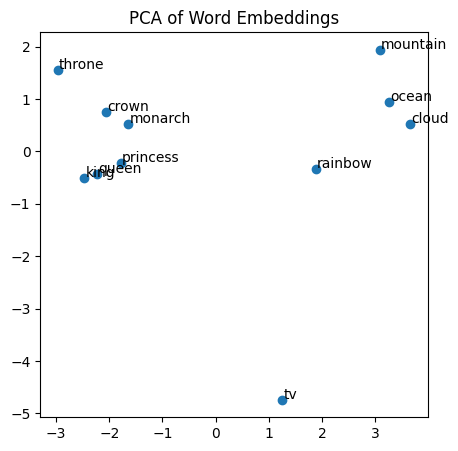

In [8]:
# Plotting
fig, axes = plt.subplots(1, 1, figsize=(5, 5))
axes.scatter(vectors_pca[:, 0], vectors_pca[:, 1])
for i, word in enumerate(words):
    axes.annotate(word, (vectors_pca[i, 0]+.02, vectors_pca[i, 1]+.02))
axes.set_title('PCA of Word Embeddings')
plt.show()

Word2Vec algebra

In [9]:
result = word_vectors.most_similar(positive=['king', 'woman'],
                                   negative=['man'], topn=1)

# Output the result
print(f"""
    The word closest to 'king' - 'man' + 'woman' is: '{result[0][0]}'
    with a similarity score of {result[0][1]}""")


    The word closest to 'king' - 'man' + 'woman' is: 'queen' 
    with a similarity score of 0.7698540687561035


GloVe vs BERT: words in context

The main reason of switching to transformers from word2vec or glove , because those two get confused in some context. The below sentence on "bat" cannot consider that words as two different vectors according to the context of the setence , these two models will always give the same vectors for the both.

sentence1 = "The bat flew out of the cave at night."
sentence2 = "He swung the bat and hit a home run."


So this issue of semantic context is solved using Transformers

This is called as Contextual token embeddings

In [13]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForMaskedLM

tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
model = AutoModelForMaskedLM.from_pretrained("google-bert/bert-base-uncased")

# Function to get BERT embeddings
def get_bert_embeddings(sentence, word):
    inputs = tokenizer(sentence, return_tensors='pt')
    outputs = model(**inputs)
    last_hidden_states = outputs.last_hidden_state
    word_tokens = tokenizer.tokenize(sentence)
    word_index = word_tokens.index(word)
    word_embedding = last_hidden_states[0, word_index + 1, :]  # +1 to account for [CLS] token
    return word_embedding

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Some weights of the model checkpoint at google-bert/bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense

In [17]:
from transformers import AutoTokenizer, AutoModel
import torch

# Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased")

# Function to get BERT embeddings
def get_bert_embeddings(sentence, word):
    inputs = tokenizer(sentence, return_tensors='pt')
    outputs = model(**inputs)
    last_hidden_states = outputs.last_hidden_state
    word_tokens = tokenizer.tokenize(sentence)
    word_index = word_tokens.index(word)
    word_embedding = last_hidden_states[0, word_index + 1, :]  # +1 to account for [CLS] token
    return word_embedding

# Test sentences
sentence1 = "The bat flew out of the cave at night."
sentence2 = "He swung the bat and hit a home run."

word = "bat"

# Get embeddings
bert_embedding1 = get_bert_embeddings(sentence1, word).detach().numpy()
bert_embedding2 = get_bert_embeddings(sentence2, word).detach().numpy()
word_embedding = word_vectors[word]
# Display embeddings
print("Embedding for 'bat' in sentence 1:", bert_embedding1)
print("Embedding for 'bat' in sentence 2:", bert_embedding2)


Embedding for 'bat' in sentence 1: [ 4.13161308e-01 -1.29082084e-01 -4.48657274e-01 -4.04926747e-01
 -1.53057337e-01 -2.78137982e-01  5.19288480e-01  1.32697809e+00
  8.37713420e-01 -8.73301804e-01  4.37873691e-01 -5.33935368e-01
 -2.88685620e-01  5.52522004e-01 -7.83518910e-01 -4.17015374e-01
  4.75097388e-01  6.28551990e-02 -5.70207477e-01 -1.67948544e-01
  4.46243793e-01 -3.54402930e-01  8.56309608e-02 -5.00467718e-01
  3.32079947e-01 -2.67047644e-01 -2.42139697e-01  1.03990567e+00
 -7.01034069e-02 -3.22732300e-01 -5.41910589e-01 -3.31707090e-01
  1.09254517e-01 -3.95513803e-01 -7.90241957e-01  2.48389408e-01
  1.83021933e-01 -3.16271305e-01 -8.12133968e-01 -6.70361459e-01
  6.26333773e-01 -3.73581380e-01  1.31090820e-01  5.10261476e-01
  1.17004588e-01  3.32127288e-02 -3.93136710e-01 -4.38964963e-01
  9.36331809e-01 -4.48058903e-01  1.56911742e-02  1.23725462e+00
 -5.99466860e-01  5.18026948e-01 -1.15018375e-02  8.61965001e-01
  5.26212975e-02 -2.73106635e-01  5.47587685e-02  2.112

In [18]:
print("BERT Embedding for 'bat' in sentence 1:", bert_embedding1[:5])
print("BERT Embedding for 'bat' in sentence 2:", bert_embedding2[:5])
print("GloVe Embedding for 'bat':", word_embedding[:5])

bert_similarity = cosine_similarity([bert_embedding1], [bert_embedding2])[0][0]
word_embedding_similarity = cosine_similarity([word_embedding], [word_embedding])[0][0]

print()
print(f"Cosine Similarity between BERT embeddings in different contexts: {bert_similarity}")
print(f"Cosine Similarity between GloVe embeddings: {word_embedding_similarity}")


BERT Embedding for 'bat' in sentence 1: [ 0.4131613  -0.12908208 -0.44865727 -0.40492675 -0.15305734]
BERT Embedding for 'bat' in sentence 2: [ 0.64066994 -0.31121498 -0.44089845 -0.16551109 -0.2005611 ]
GloVe Embedding for 'bat': [-0.47601  0.81705  0.11151 -0.22687 -0.80672]

Cosine Similarity between BERT embeddings in different contexts: 0.459957480430603
Cosine Similarity between GloVe embeddings: 1.0
